<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/PerformerIAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!uname -a

Linux 40e2ae908d75 5.4.109+ #1 SMP Tue Apr 20 19:55:43 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
!nvidia-smi

Mon May 10 21:14:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install performer-pytorch

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp37-none-any.whl size=2905 sha256=019c984902b25f323fd559c77770a3da71af454c4e0e5502f23fb95d9a8d9573
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
Successfully built axial-positional-embedding


In [4]:
!pip install vit-pytorch

In [5]:
!pip install colorama

In [6]:
import os
import cv2
import sys
import random
import torch
import collections
import editdistance
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from colorama import Fore
from itertools import groupby
import albumentations as A
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt
from vit_pytorch.vit import PreNorm, Attention, Transformer
from performer_pytorch import Performer
from albumentations.pytorch import ToTensor

In [7]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/MyDrive/IAM-lines.tgz

/content/gdrive/MyDrive/IAM-lines.tgz


In [9]:
!cp  /content/gdrive/MyDrive/IAM-lines.tgz .

In [10]:
!rm -rf data; mkdir data; mv IAM-lines.tgz data/

In [11]:
!cd data; tar -zxf IAM-lines.tgz; cd -

/content


In [12]:
!tail -10 data/lines/lines.txt.test

r06-103-05 err 185 17 351 1630 1601 137 confessed|everything|.|Her|fiance*?2
r06-106-00 ok 185 16 340 731 1650 141 The|day|I|promised|to|take|Catherine
r06-106-01 ok 184 21 342 915 1718 136 down|to|visit|my|young|friend|Philip
r06-106-08 ok 182 18 351 2172 1816 132 Renoir|girl|who|expects|everything|from
r06-111-05 ok 181 16 347 1645 1765 113 romantic|than|large|houses|.|We|drank
r06-111-08 ok 182 13 354 2167 1173 131 thing|from|food|to|music|.
r06-115-04 err 185 20 370 1444 1743 143 I|suggested|she|might|find|them|dif-
r06-115-09 ok 183 14 351 2359 1793 115 pages|of|Babel|,|for|she|was|determined
r06-121-04 ok 184 13 336 1451 1642 138 their|bright|friendly|heads|turned
r06-121-10 ok 183 16 353 2530 1769 117 the|pictures|just|for|the|fun|of|it|was


In [13]:
def list_files_and_basename_recursive(dirpath, ext):
    # TODO unit test
    retlist = {}
    for root, dirs, files in os.walk(dirpath):
        for filename in files:
            if not filename.endswith(ext):
                continue

            image_filename_no_ext = os.path.basename(os.path.splitext(filename)[0])
            retlist[image_filename_no_ext] = os.path.join(root, filename)

    return retlist

In [14]:
from PIL import Image
from torch.utils.data.dataloader import default_collate
from typing import Callable, Dict, List, Set

In [15]:
class Vocabulary(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (Iterable): set of the possible characters.
        ignore_case (bool, default=False): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet: List):
        self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i

    @property
    def num_classes(self):
        return len(self.dict)

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [self.dict[char] for char in text]
            length = [len(text)]
        elif isinstance(text, torch.Tensor):
            if text.dim() == 2:
                label = []
                length = []
                for sub in text:
                    label_char = [self.dict[str(x)] for x in sub.tolist()]
                    label.append(label_char)
                    length.append(len(sub))
                text = label
            else:
                text = [self.dict[str(x)] for x in text.tolist()]
                length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = "".join(text)
            text, _ = self.encode(text)
        else:
            raise ValueError(f"Invalid input type {type(text)}")

        return torch.IntTensor(text), torch.IntTensor(length)

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert (
                t.numel() == length
            ), "text with length: {} does not match declared length: {}".format(
                t.numel(), length
            )
            if raw:
                return "".join(
                    [self.alphabet[i] if self.alphabet[i] != "<SEP>" else "" for i in t]
                )
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        c = self.alphabet[t[i]]
                        if c == "<SEP>":
                            c = " "
                        char_list.append(c)
                return "".join(char_list)
        else:
            # batch mode
            assert (
                t.numel() == length.sum()
            ), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum()
            )
            texts = []
            index = 0
            for i in range(length.numel()):
                label_length = length[i]
                texts.append(
                    self.decode(
                        t[index : index + label_length],
                        torch.IntTensor([label_length]),
                        raw=raw,
                    )
                )
                index += label_length
            return texts


In [16]:
def base_collator_with_padding(
    pad_key, base_collator_fn=default_collate, pad_val=0, pad_idx=0
):
    """Pad: a given key in the data iterator output to a consistent length.
    Otherwise, falls back to default collate functionality
    Args:
        pad_key: str The specific data stream to pad
        base_collator_fn: Callable The default collator to call. Defaults to default_collate from PyTorch
        pad_val: Any The value to pad in the tensor. Defaults to 0
    Returns:
        The result of collation, including padding of the variable length streams
    """

    def fn(batch):
        max_len = max(item[pad_key].shape[pad_idx] for item in batch)

        for item in batch:
            original_tensor = item[pad_key]

            # TODO currently assumes a single dimension tensor
            padded_tensor = torch.full((max_len,), pad_val, dtype=original_tensor.dtype)
            padded_tensor[: original_tensor.shape[pad_idx]] = original_tensor

            item[pad_key] = padded_tensor

        return base_collator_fn(batch)

    return fn


In [17]:
class IAMLinesDataset(torch.utils.data.Dataset):
    LINE_LEVEL_FIELDNAMES = [
        "line_id",
        "line_segmentation_result",
        "graylevel",
        "components",
        "bbox_x",
        "bbox_y",
        "bbox_w",
        "bbox_h",
        "label",
    ]

    def __init__(
        self,
        image_directory: str,
        lines_file: str,
        image_extension: str = "png",
        transform: Callable = None,
        max_sequence_len=None,
    ):
        self._data = []
        self._transform = transform

        image_filepaths = list_files_and_basename_recursive(
            image_directory, image_extension
        )

        chars: Set[str] = set()

        self._limit_max_sequence_length = bool(max_sequence_len)

        # either set it to our upper limit, or initialize it to be overridden by our longest sequence
        self._max_sequence_length = (
            max_sequence_len if self._limit_max_sequence_length else -1
        )

        with open(lines_file) as fp:
            # QUOTE_NONE is required here, there are some open double quotes in the file that screw with parsing
            reader = csv.DictReader(
                fp,
                fieldnames=self.LINE_LEVEL_FIELDNAMES,
                delimiter=" ",
                quoting=csv.QUOTE_NONE,
            )
            for row in reader:
                data_dict = {
                    "image_filepath": image_filepaths[row["line_id"]],
                }

                label_str = row["label"]
                label_str = label_str.replace("|", " ")
                label_len = len(label_str)
                if self._limit_max_sequence_length:
                    label_str = label_str[: self._max_sequence_length]
                    new_label_len = len(label_str)
                    if label_len != new_label_len:
                        warnings.warn(
                            f"Had to truncate image label {row['word_id']}, label string too long "
                            f"(was {label_len}, limit {self._max_sequence_length})"
                        )

                elif label_len > self._max_sequence_length:
                    self._max_sequence_length = label_len

                chars.update(label_str)

                data_dict["label"] = label_str
                self._data.append(data_dict)

        # Could be an issue if the train set doesn't have some symbols.

        # NOTE index 0 is our blank space index
        self.vocab = Vocabulary(["<SEP>"] + sorted(chars))

    # TODO num_classes and max_seq_len should be precalculated
    @property
    def num_classes(self):
        return self.vocab.num_classes

    @property
    def max_sequence_len(self):
        return self._max_sequence_length

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        data_at_idx = self._data[idx]
        image_filepath = data_at_idx["image_filepath"]
        image_label = data_at_idx["label"]

        image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (500, 50), cv2.INTER_AREA)

        # invert the image
        image = image.max() - image
        if self._transform:
            image = self._transform(image=image)['image']
            image = image.permute(1, 0)

        label_indices, label_length = self.vocab.encode(image_label)

        return {
            "image": image,
            "label_indices": label_indices,
            "label_length": label_length,
            "label_str": image_label,
        }

In [18]:
import csv

In [19]:
train_transform = A.Compose([
    #A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=3, p=0.5),
    #A.OpticalDistortion(p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [20]:
MAX_SEQ_LEN = 93
trainset = IAMLinesDataset(
    '/content/data/lines',
    '/content/data/lines/lines.txt.train',
    transform=train_transform,
    max_sequence_len=MAX_SEQ_LEN,
)

In [21]:
train_iter = iter(trainset)

In [22]:
data = next(train_iter)

In [23]:
data

{'image': tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 'label_indices': tensor([28,  1, 40, 42, 49, 32,  1, 73, 68,  1, 72, 73, 68, 69,  1, 40, 71, 13,
          1, 34, 54, 62, 73, 72, 64, 58, 65, 65,  1, 59, 71, 68, 66],
        dtype=torch.int32),
 'label_length': tensor([33], dtype=torch.int32),
 'label_str': 'A MOVE to stop Mr. Gaitskell from'}

In [24]:
data['image'].shape

torch.Size([50, 500])

In [25]:
data['label_str']

'A MOVE to stop Mr. Gaitskell from'

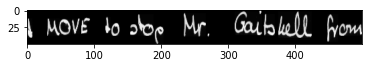

In [26]:
plt.imshow(data['image'], cmap='gray')

In [27]:
val_transform = A.Compose([
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [28]:
testset = IAMLinesDataset(
    '/content/data/lines',
    '/content/data/lines/lines.txt.test',
    transform=val_transform,
    max_sequence_len=MAX_SEQ_LEN,
)

In [29]:
max_h=0
max_w=0
max_l=0
vocab = set()
for data in trainset:
  img = data['image']
  max_w = max(max_w, img.shape[1])
  max_h = max(max_h, img.shape[0])
  text = data['label_str']
  max_l = max(max_l, len(text))
  for c in text:
    if c not in vocab:
      vocab.add(c)
print(f'Max height={max_h}, width={max_w}, label={max_l}')
vocab = list(vocab)
vocab.sort()
print(''.join(vocab))

Max height=50, width=500, label=93
 !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [30]:
len(vocab)

79

In [31]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

In [32]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.nn import Conv2d, Dropout, LogSoftmax
from einops.layers.torch import Rearrange

In [33]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, 
                 depth, heads, mlp_dim, pool = 'mean', channels = 3, 
                 dim_head = 64, dropout = 0., emb_dropout = 0.,
                 patch_method = "linear", transformer='regular'):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        if patch_method == "linear":
          self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
          )
        else:
          self.to_patch_embedding = nn.Conv2d(
            in_channels=channels,
            out_channels=dim,
            kernel_size=patch_size,
            stride=patch_size,
          )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        if transformer == 'performer':
          self.transformer = Performer(dim=dim, depth=depth, 
                                       heads=heads, dim_head=dim_head,
                                       attn_dropout=dropout,
                                       causal=True)
        else:
          self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        self._log_softmax = LogSoftmax(dim=-1)

    def forward(self, img):
        #print(f'Image shape: {img.shape}')
        x = self.to_patch_embedding(img)
        # convolutional embedding produces an extra dimension
        if len(x.shape) == 4:
          x = x.flatten(2)
          x = x.transpose(-1, -2)
        #print(f'After patch embedding: {x.shape}')
        b, n, _ = x.shape

        x += self.pos_embedding[:, :n]
        #print(f'after pos embedding: {x.shape}')
        x = self.dropout(x)
        #print(f'Before transformer: {x.shape}')
        x = self.transformer(x)
        #print(f'After transformer: {x.shape}')

        batch_len, sequence_len, hidden_len = x.shape

        x = x.reshape(-1, hidden_len)
        logits = self.mlp_head(x)
        logits = logits.view(batch_len, sequence_len, -1)
        logits = self._log_softmax(logits)
        logits = logits.permute(1, 0, 2)
        
        #print(f'After logits: {logits.shape}')
        return logits

In [34]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, collate_fn=base_collator_with_padding("label_indices"), shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, collate_fn=base_collator_with_padding("label_indices"), shuffle=True)

In [35]:
#model = CRNN()
model = ViT(image_size=(50, 500), patch_size=(50, 5), num_classes=(len(vocab)+1),
            depth=6, dim=512, mlp_dim=2048, heads=8, channels=1, 
            patch_method="cnn", transformer='performer')

unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


In [36]:
x = torch.randn(1,1,50,500)
out = model(x)
out.shape

torch.Size([100, 1, 80])

In [37]:
model = model.cuda()

In [38]:
# load pre-trained weights
if os.path.exists("/content/gdrive/MyDrive/PerfViT_IAM.pth"):
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/PerfViT_IAM.pth"))

In [39]:
blank_label = len(vocab)

In [40]:
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, verbose=True)

In [41]:
print(f"Model has {count_parameters(model):.2f}M parameters")

Model has 19.14M parameters


In [42]:
epochs=25

In [43]:
def create_logit_lengths(batch_size, sequence_length):
    return torch.full((batch_size,), sequence_length, dtype=torch.int64)

In [ ]:
# ================================================ TRAINING MODEL ======================================================
best_ed = np.inf
for epoch in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    model.train()
    train_loss = 0.0
    train_ed = 0
    train_cc = 0
    for data in tqdm(train_loader,
                     position=0, leave=True,
                     file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        tensor_keys = ["image", "label_indices", "label_length"]
        images, label_indices, label_lengths = tuple(
            data[k].cuda() for k in tensor_keys
        )

        b, h, w = images.shape
        images = images.reshape(b, 1 , h, w)

        optimizer.zero_grad()
        
        y_pred = model(images)

        l = create_logit_lengths(y_pred.shape[1], y_pred.shape[0]) 
        loss = criterion(y_pred, label_indices, l, label_lengths)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(b):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction):
              text = [vocab[k] for k in prediction]
              train_ed += editdistance.eval(text, data['label_str'][i])
            else:
              train_ed += len(data['label_str'][i])  # the entire string is missing
            train_cc += len(data['label_str'][i])
            train_total += 1
    print(f'TRAINING. editdistance: {train_ed}/{train_total}={train_ed/train_total:.3f}')
    print(f"[{epoch}] Train loss: {train_loss:.2f}, avg. char count={train_cc/train_total:.3f}")

    scheduler.step(train_loss)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    model.eval()
    val_loss = 0.0
    val_ed = 0
    val_cc = 0
    TO_DISPLAY = 10
    for data in test_loader:
        tensor_keys = ["image", "label_indices", "label_length"]
        images, label_indices, label_lengths = tuple(
            data[k].cuda() for k in tensor_keys
        )

        b, h, w = images.shape
        images = images.reshape(b, 1 , h, w)
        
        with torch.set_grad_enabled(False):
            y_pred = model(images)
        
        y_pred = model(images)

        l = create_logit_lengths(y_pred.shape[1], y_pred.shape[0]) 
        loss = criterion(y_pred, label_indices, l, label_lengths)

        val_loss += loss.item()

        _, max_index = torch.max(y_pred, dim=2)
        for i in range(b):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction):
              text = ''.join([vocab[k] for k in prediction])
              val_ed += editdistance.eval(text, data['label_str'][i])
            else:
              text = ''
              val_ed += len(data['label_str'][i])
            val_cc += len(data['label_str'][i])
            val_total += 1
            if val_total < TO_DISPLAY:
              print(f"Output={text}\t Label={data['label_str'][i]}")
    # save best weights
    if val_ed < best_ed:
      best_ed = val_ed
      print(f"Best model seen [{best_ed:.2f}], saving weights...")
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/PerfViT_IAM.pth")
    print(f'TESTING editdistance:  {val_ed}/{val_total} = {val_ed/val_total:.3f}')
    print(f"[{epoch}] Test loss: {val_loss:.2f}, avg char count: {val_cc/val_total:.3f}")


100%|██████████| 752/752 [08:18<00:00,  1.51it/s]
TRAINING. editdistance: 505507/12032=42.014
[0] Train loss: 2212.18, avg. char count=43.230
Output=uf!!!bfu!f	 Label=ones ) , is becoming quite an accomplished actress .
Output=uu!!!u!h!/	 Label=too long .
Output=!!fu!f!uiff!/	 Label=public of the change .
Output=u!p!fuff!f!f	 Label=than forty or fifty days after preparation , the
Output=p!!f!/	 Label=pro-western centre and south .
Output=pf!f!!b!f!u	 Label=of the strontium sulphate is incomplete . Using
Output=Ui!	 Label=Table 1 shows the decontamination factors
Output=f!!b!f!i!f	 Label=original stand . Only where the issues were
Output=Ui!f!!f!fff	 Label=towns , grey , rose-headed mariners clinging
Best model seen [54742.00], saving weights...
TESTING editdistance:  54742/1321 = 41.440
[0] Test loss: 244.36, avg char count: 42.867
100%|██████████| 752/752 [08:23<00:00,  1.49it/s]
TRAINING. editdistance: 505252/12032=41.992
[1] Train loss: 2194.72, avg. char count=43.230
Output=bf!!p!f

In [45]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/PerfViT_IAM.pth")

In [76]:
data['image'].shape

(50, 500)

In [ ]:
count=0
COUNT=40
for x_val, y_val in val_loader:
    batch_size = x_val.shape[0]
    # x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], -1)
    t, l = encoder.encode(y_val)

    with torch.set_grad_enabled(False):
        y_pred = model(x_val.cuda())

    y_pred = y_pred.permute(1, 0, 2)
    _, max_index = torch.max(y_pred, dim=2)
    for i in range(batch_size):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
        try:
          if len(prediction):
            text = ''.join([vocab[k] for k in prediction])
            print(f"Output={text},\t Label={y_val[i]}")
        except IndexError:
          pass
        count += 1
    if count > COUNT:
      break

In [ ]:
from einops.layers.torch import Rearrange

In [ ]:
img = torch.randn(1,1,32,512)

In [ ]:
R = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 32, p2 = 8)

In [ ]:
r = R(img)
r.shape

torch.Size([1, 64, 256])

In [ ]:
transformer = Performer(
    dim=512,
    depth=1,
    heads=8,
    dim_head=64,
    causal=True
)

unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


In [ ]:
model = ViT(
    image_size=512,
    patch_size=8,
    num_classes=11,
    dim=512,
    channels=1,
    transformer=transformer,
)

In [ ]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=64, out_features=512, bias=True)
  )
  (transformer): Performer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fn): SelfAttention(
              (fast_attention): FastAttention(
                (kernel_fn): ReLU()
              )
              (to_q): Linear(in_features=512, out_features=512, bias=True)
              (to_k): Linear(in_features=512, out_features=512, bias=True)
              (to_v): Linear(in_features=512, out_features=512, bias=True)
              (to_out): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (1): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_a

In [ ]:
x = torch.randn(1, 16, 32)

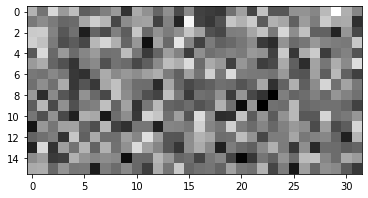

In [ ]:
plt.imshow(x.squeeze(0), cmap='gray')

In [ ]:
out = model(x.unsqueeze(0))
out.shape

torch.Size([1, 11])

In [ ]:
out

tensor([[ 1.8996, -0.0451,  0.5881, -0.6383, -0.5154, -0.7162, -0.1623,  0.5851,
         -0.4277,  0.7611,  0.6347]], grad_fn=<AddmmBackward>)